# TD Ameritrade: Options Chain & Greeks

## Purpose Of This Project Is To Demonstrate Via Python + TD Ameritrade API
* Pulling options chain for a single stock & viewing in a dataframe
* Graphically view the greeks and additional attributes

#### Reference Links
* https://developer.tdameritrade.com/
* https://tda-api.readthedocs.io/en/latest/index.html

#### Webdriver to manager chrome driver for selenium
* This is to handle error message for driver being outdated
* https://www.youtube.com/watch?v=mAwL_0N1W9E

In [1]:
# pip install webdriver-manager

In [2]:
# pip install selenium

In [3]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

#### Key Parameters From TD App.
* This assumes app is already created

In [4]:
#Could be a stand alone .py file that you import in the next step
token_path = 'token'
api_key = 'APIKEY@AMER.OAUTHAP' # make sure this ends in @AMER.OAUTHAP
redirect_uri = 'https://localhost'

## Connect To TD Ameritrade & Explore Data

#### insipired by adamgetbags

In [5]:
# pip install tda-api

In [6]:
# Connection
from tda import auth, client
import json
import pandas as pd
from datetime import datetime, date

# import TDASecrets could go here too

try:
    c = auth.client_from_token_file(token_path, api_key)
except FileNotFoundError:
    from selenium import webdriver
#     with webdriver.Chrome() as driver:
# This leverages webdriver_manager. The code above is if you were not using webdriver_manager
    with webdriver.Chrome(service = Service(ChromeDriverManager().install())) as driver:
        c = auth.client_from_login_flow(
            driver, api_key, redirect_uri,
            token_path)

In [7]:
#get all options
# additional filtering can be done. Consult the documentation for details
stockSymbol = 'AAPL'
# stockSymbol = 'VIX'
r = c.get_option_chain(symbol = stockSymbol,
                        contract_type = c.Options.ContractType.ALL)

#### Field Exploration

In [8]:
# print keys
print(r.json().keys())

dict_keys(['symbol', 'status', 'underlying', 'strategy', 'interval', 'isDelayed', 'isIndex', 'interestRate', 'underlyingPrice', 'volatility', 'daysToExpiration', 'numberOfContracts', 'putExpDateMap', 'callExpDateMap'])


In [9]:
# 3 = dates. This is the options expiring at the 3rd index
# 2 = strike. This is the strike at the 2nd index
data = r.json()['callExpDateMap'][
# specific expiration
        list(r.json()['callExpDateMap'].keys())[3]][
# specific strike
        list(r.json()['callExpDateMap'][
        list(r.json()['callExpDateMap'].keys())[0]].keys())[2]][0]

In [10]:
data.keys()

dict_keys(['putCall', 'symbol', 'description', 'exchangeName', 'bid', 'ask', 'last', 'mark', 'bidSize', 'askSize', 'bidAskSize', 'lastSize', 'highPrice', 'lowPrice', 'openPrice', 'closePrice', 'totalVolume', 'tradeDate', 'tradeTimeInLong', 'quoteTimeInLong', 'netChange', 'volatility', 'delta', 'gamma', 'theta', 'vega', 'rho', 'openInterest', 'timeValue', 'theoreticalOptionValue', 'theoreticalVolatility', 'optionDeliverablesList', 'strikePrice', 'expirationDate', 'daysToExpiration', 'expirationType', 'lastTradingDay', 'multiplier', 'settlementType', 'deliverableNote', 'isIndexOption', 'percentChange', 'markChange', 'markPercentChange', 'intrinsicValue', 'nonStandard', 'inTheMoney', 'mini', 'pennyPilot'])

### Pull All Call Options And Put Into A Dataframe
* This is going to identify how many expiration dates there are
* This will then determine how many strikes there are while looking at each expiration date
* For each expiration date, loop through all strikes
* View the greeks & other attributes for the option chain

In [11]:
data_final = pd.DataFrame(columns=data.keys())
data_final.head()

,putCall,symbol,description,exchangeName,bid,ask,last,mark,bidSize,askSize,...,deliverableNote,isIndexOption,percentChange,markChange,markPercentChange,intrinsicValue,nonStandard,inTheMoney,mini,pennyPilot


In [12]:
callExp_num = len(r.json()['callExpDateMap'])
for e in range(0,callExp_num):
    strikeExp_num = len(r.json()['callExpDateMap'][
        list(r.json()['callExpDateMap'].keys())[e]])
    
    for s in range(0,strikeExp_num):
        try:
            data_setup = r.json()['callExpDateMap'][
                    # specific expiration
                            list(r.json()['callExpDateMap'].keys())[e]][
                    # specific strike
                            list(r.json()['callExpDateMap'][
                            list(r.json()['callExpDateMap'].keys())[0]].keys())[s]][0]
            df_normalize = pd.json_normalize(data_setup)
            df_normalize["stockSymbol"] = stockSymbol
            data_final = data_final.append(df_normalize,ignore_index =True)
        except:
            pass

In [13]:
data_final.head(5)
data_final.to_csv("data_final_chain_to_review.csv")

In [14]:
# Since I am mostly interested in the greeks, I'll pull in just the key columns I want
filtered_column_headers = ['putCall','symbol','description','bid','ask','mark','totalVolume','volatility',
    'delta','gamma','theta','vega','rho','openInterest','strikePrice','daysToExpiration','inTheMoney','stockSymbol']

In [15]:
df_filtered = data_final[filtered_column_headers]
df_filtered.head()

,putCall,symbol,description,bid,ask,mark,totalVolume,volatility,delta,gamma,theta,vega,rho,openInterest,strikePrice,daysToExpiration,inTheMoney,stockSymbol
0,CALL,AAPL_042123C50,AAPL Apr 21 2023 50 Call,114.5,116.10,115.30,0,NaN,NaN,NaN,NaN,0.0,NaN,1173,50.0,4,True,AAPL
1,CALL,AAPL_042123C60,AAPL Apr 21 2023 60 Call,104.5,106.10,105.30,0,276.874,1.0,0.0,-0.022,0.0,0.008,187,60.0,4,True,AAPL
2,CALL,AAPL_042123C65,AAPL Apr 21 2023 65 Call,99.5,101.10,100.30,1,255.808,1.0,0.0,-0.023,0.0,0.008,114,65.0,4,True,AAPL
3,CALL,AAPL_042123C70,AAPL Apr 21 2023 70 Call,95.0,95.65,95.33,0,NaN,NaN,NaN,NaN,0.0,NaN,217,70.0,4,True,AAPL
4,CALL,AAPL_042123C75,AAPL Apr 21 2023 75 Call,90.0,91.05,90.53,0,NaN,NaN,NaN,NaN,0.0,NaN,118,75.0,4,True,AAPL


In [17]:
# df_filtered.to_csv("OptionsChain_Review.csv")
print('Option Chain Pull Complete - Please Review')

Option Chain Pull Complete - Please Review


## Graph Greeks In Option Chain

In [18]:
# Get list of unique DTE
list_DTE = df_filtered['daysToExpiration'].unique()

# picking DTE. Can be hard coded
list_DTE[int(round(len(list_DTE)/2-1,0))]

151

In [19]:
dte_filter = list_DTE[int(round(len(list_DTE)/2-1,0))]
df = df_filtered[df_filtered['daysToExpiration']==dte_filter]
# df = df_filtered
df.head(5)

,putCall,symbol,description,bid,ask,mark,totalVolume,volatility,delta,gamma,theta,vega,rho,openInterest,strikePrice,daysToExpiration,inTheMoney,stockSymbol
399,CALL,AAPL_091523C65,AAPL Sep 15 2023 65 Call,100.60,101.60,101.10,0,57.331,0.992,0.0,-0.005,0.010,0.259,2,65.0,151,True,AAPL
400,CALL,AAPL_091523C70,AAPL Sep 15 2023 70 Call,95.75,96.80,96.28,0,55.254,0.991,0.0,-0.007,0.013,0.279,6146,70.0,151,True,AAPL
401,CALL,AAPL_091523C75,AAPL Sep 15 2023 75 Call,90.90,91.70,91.30,0,52.798,0.989,0.0,-0.008,0.017,0.3,1639,75.0,151,True,AAPL
402,CALL,AAPL_091523C80,AAPL Sep 15 2023 80 Call,86.10,86.80,86.45,0,50.636,0.988,0.0,-0.009,0.022,0.319,802,80.0,151,True,AAPL
403,CALL,AAPL_091523C85,AAPL Sep 15 2023 85 Call,81.20,82.25,81.72,2,48.407,0.985,0.0,-0.011,0.027,0.338,708,85.0,151,True,AAPL


In [20]:
df.columns

Index(['putCall', 'symbol', 'description', 'bid', 'ask', 'mark', 'totalVolume',
       'volatility', 'delta', 'gamma', 'theta', 'vega', 'rho', 'openInterest',
       'strikePrice', 'daysToExpiration', 'inTheMoney', 'stockSymbol'],
      dtype='object')

<Axes: xlabel='strikePrice', ylabel='delta'>

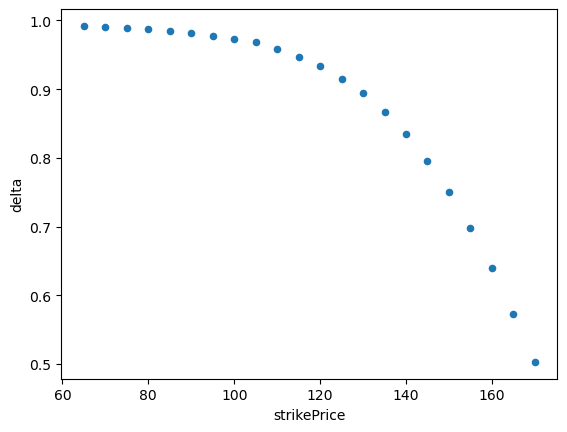

In [21]:
df.plot(x='strikePrice', y='delta', kind='scatter')

<Axes: xlabel='strikePrice', ylabel='theta'>

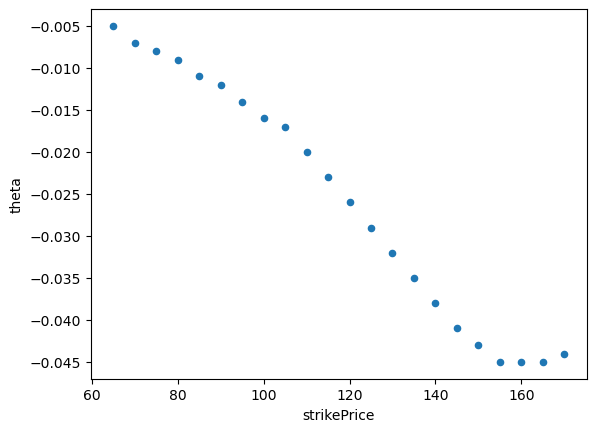

In [22]:
df.plot(x='strikePrice', y='theta', kind='scatter')

<Axes: xlabel='strikePrice', ylabel='theta'>

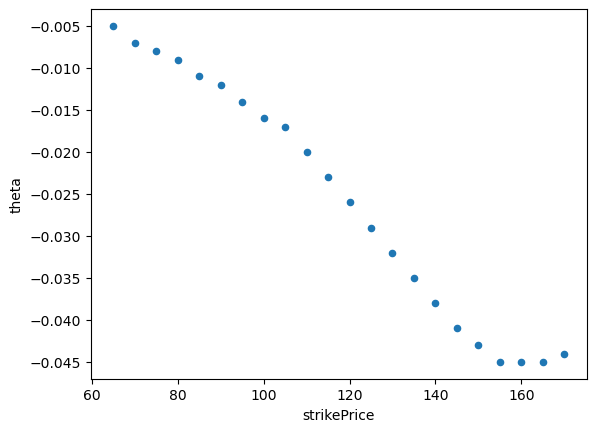

In [23]:
df.plot(x='strikePrice', y='theta', kind='scatter')

<Axes: xlabel='strikePrice', ylabel='vega'>

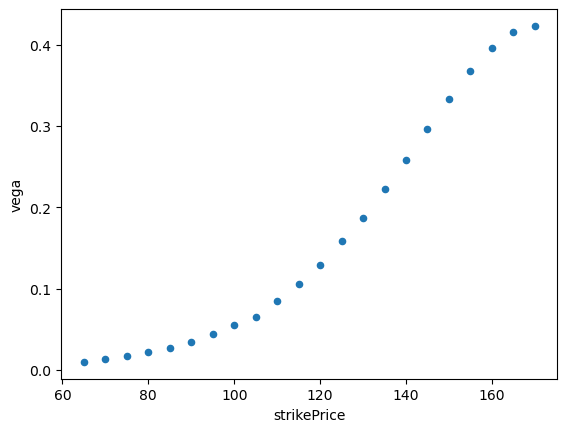

In [24]:
df.plot(x='strikePrice', y='vega', kind='scatter')

<Axes: xlabel='strikePrice', ylabel='rho'>

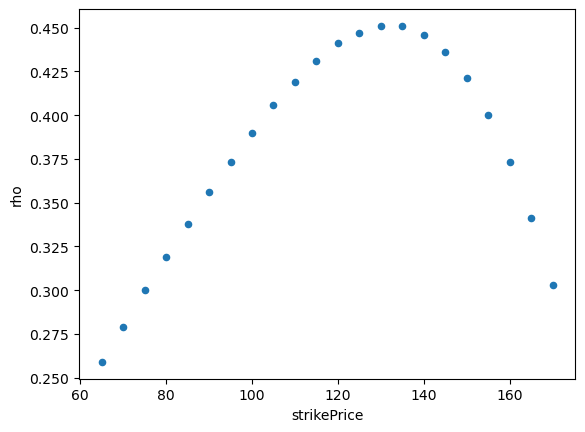

In [25]:
df.plot(x='strikePrice', y='rho', kind='scatter')

<Axes: xlabel='strikePrice', ylabel='volatility'>

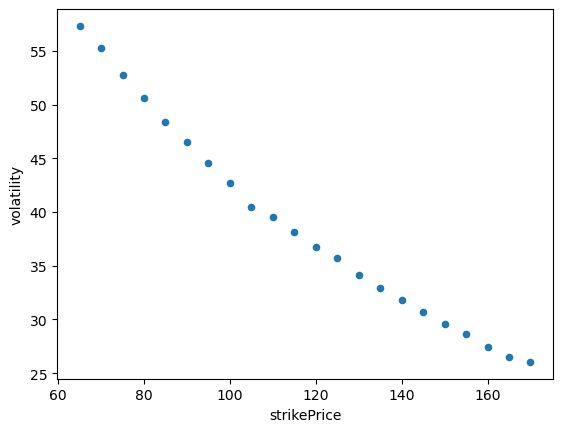

In [26]:
df.plot(x='strikePrice', y='volatility', kind='scatter')

<Axes: xlabel='strikePrice', ylabel='openInterest'>

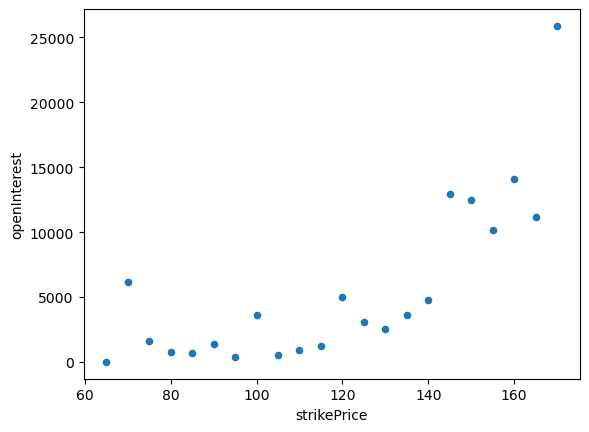

In [27]:
df.plot(x='strikePrice', y='openInterest', kind='scatter')